 # 图像的语义分割

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import glob

tf.__version__

'2.0.0'

## 数据集示例

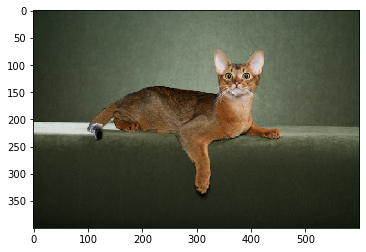

In [2]:
# 读取图片
img = tf.io.read_file("dataset/Oxford_IIIT/images/Abyssinian_1.jpg")
img = tf.image.decode_jpeg(img)
plt.imshow(img)

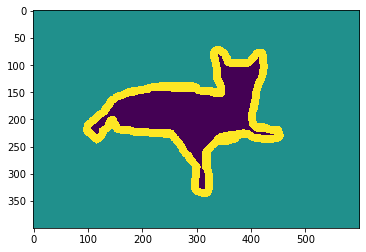

In [3]:
# 读取标签图
img = tf.io.read_file("dataset/Oxford_IIIT/annotations/trimaps/Abyssinian_1.png")
img = tf.image.decode_png(img)
plt.imshow(tf.squeeze(img))

In [4]:
# 标签图片是三分类：背景，轮廓，物体
np.unique(img.numpy())

array([1, 2, 3], dtype=uint8)

## 创建输入dataset

In [5]:
image_path = glob.glob("dataset/Oxford_IIIT/images/*.jpg")
image_path[:3]

['dataset/Oxford_IIIT/images\\Abyssinian_1.jpg',
 'dataset/Oxford_IIIT/images\\Abyssinian_10.jpg',
 'dataset/Oxford_IIIT/images\\Abyssinian_100.jpg']

In [6]:
label_path = glob.glob("dataset/Oxford_IIIT/annotations/trimaps/*.png")
label_path[:3]

['dataset/Oxford_IIIT/annotations/trimaps\\Abyssinian_1.png',
 'dataset/Oxford_IIIT/annotations/trimaps\\Abyssinian_10.png',
 'dataset/Oxford_IIIT/annotations/trimaps\\Abyssinian_100.png']

In [7]:
len(image_path), len(label_path)

(7390, 7390)

### 将图片路径按照名字进行排序，保证图片和标签一一对应

In [8]:
# 截取路径的名字部分
image_path[0].split('\\')[-1].split('.')[0]

'Abyssinian_1'

In [9]:
# 按照名字部分进行排序
image_path.sort(key=lambda x: x.split('\\')[-1].split('.')[0])
label_path.sort(key=lambda x: x.split('\\')[-1].split('.')[0])
image_path[:3], label_path[:3]

(['dataset/Oxford_IIIT/images\\Abyssinian_1.jpg',
  'dataset/Oxford_IIIT/images\\Abyssinian_10.jpg',
  'dataset/Oxford_IIIT/images\\Abyssinian_100.jpg'],
 ['dataset/Oxford_IIIT/annotations/trimaps\\Abyssinian_1.png',
  'dataset/Oxford_IIIT/annotations/trimaps\\Abyssinian_10.png',
  'dataset/Oxford_IIIT/annotations/trimaps\\Abyssinian_100.png'])

In [10]:
# 将路径进行乱序
# 获得乱序的序号
np.random.seed(2019)
index = np.random.permutation(len(image_path))
# 对图片和标签乱序
image_path = np.array(image_path)[index]
label_path = np.array(label_path)[index]
image_path[:3], label_path[:3]

(array(['dataset/Oxford_IIIT/images\\newfoundland_22.jpg',
        'dataset/Oxford_IIIT/images\\scottish_terrier_12.jpg',
        'dataset/Oxford_IIIT/images\\miniature_pinscher_155.jpg'],
       dtype='<U61'),
 array(['dataset/Oxford_IIIT/annotations/trimaps\\newfoundland_22.png',
        'dataset/Oxford_IIIT/annotations/trimaps\\scottish_terrier_12.png',
        'dataset/Oxford_IIIT/annotations/trimaps\\miniature_pinscher_155.png'],
       dtype='<U74'))

### 创建dataset

In [11]:
# 创建路径dataset
dataset = tf.data.Dataset.from_tensor_slices((image_path, label_path))
dataset

<TensorSliceDataset shapes: ((), ()), types: (tf.string, tf.string)>

In [12]:
# 加载图片
def load_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    img = img / 255.0
    return img
# 加载标签
def load_label(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=1)
    img = tf.image.resize(img, (224, 224))
    # 将标签从(1, 2, 3)转为(0, 1, 2)
    img = img - 1
    return img
def load_data(img_path, label_path):
    return load_image(img_path), load_label(label_path)

In [13]:
dataset = dataset.map(load_data)
dataset

<MapDataset shapes: ((224, 224, 3), (224, 224, 1)), types: (tf.float32, tf.float32)>

In [14]:
# 分离训练集和验证集
train_num = int(len(image_path) * 0.8)
val_num = len(image_path) - train_num
train_data = dataset.take(train_num)
validation_data = dataset.skip(train_num)

In [15]:
BATCH_SIZE = 16
train_data = train_data.shuffle(100).repeat().batch(BATCH_SIZE)
validation_data = validation_data.batch(BATCH_SIZE)
train_data, validation_data

(<BatchDataset shapes: ((None, 224, 224, 3), (None, 224, 224, 1)), types: (tf.float32, tf.float32)>,
 <BatchDataset shapes: ((None, 224, 224, 3), (None, 224, 224, 1)), types: (tf.float32, tf.float32)>)

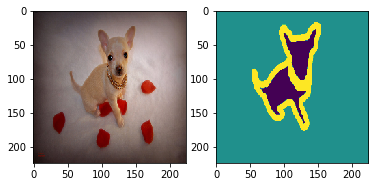

In [16]:
# dataset样例
# 得到一个batch数据
for imgs, labels in train_data.take(1):
    plt.subplot(1, 2, 1)
    plt.imshow(imgs[0])
    plt.subplot(1, 2, 2)
    plt.imshow(tf.squeeze(labels[0]))

## 构建模型

In [17]:
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [18]:
# base_model.trainable = False
x = base_model.output
# 取出跳接结构的输出
skip_connection_layers = ['block5_conv3', 'block4_conv3', 'block3_conv3']
block5_conv3_out, block4_conv3_out, block3_conv3_out = [base_model.get_layer(layer).output for layer in skip_connection_layers]
x, block5_conv3_out, block4_conv3_out, block3_conv3_out

(<tf.Tensor 'block5_pool/Identity:0' shape=(None, 7, 7, 512) dtype=float32>,
 <tf.Tensor 'block5_conv3/Identity:0' shape=(None, 14, 14, 512) dtype=float32>,
 <tf.Tensor 'block4_conv3/Identity:0' shape=(None, 28, 28, 512) dtype=float32>,
 <tf.Tensor 'block3_conv3/Identity:0' shape=(None, 56, 56, 256) dtype=float32>)

In [19]:
# 上采样
x = tf.keras.layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
# 加一层卷积提取特征
x = tf.keras.layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
# 与 block5_conv3_out 进行连接
x = tf.add(x, block5_conv3_out)
x.shape

TensorShape([None, 14, 14, 512])

In [20]:
# 上采样
x = tf.keras.layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
# 加一层卷积提取特征
x = tf.keras.layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
# 与 block4_conv3_out 进行连接
x = tf.add(x, block4_conv3_out)
x.shape

TensorShape([None, 28, 28, 512])

In [21]:
# 上采样
x = tf.keras.layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
# 加一层卷积提取特征
x = tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
# 与 block3_conv3_out 进行连接
x = tf.add(x, block3_conv3_out)
x.shape

TensorShape([None, 56, 56, 256])

In [22]:
# 连续两次上采样，使得输出与输入图片大小一样
x = tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
x = tf.keras.layers.Conv2DTranspose(3, (3, 3), strides=(2, 2), padding='same', activation='softmax')(x)
x.shape

TensorShape([None, 224, 224, 3])

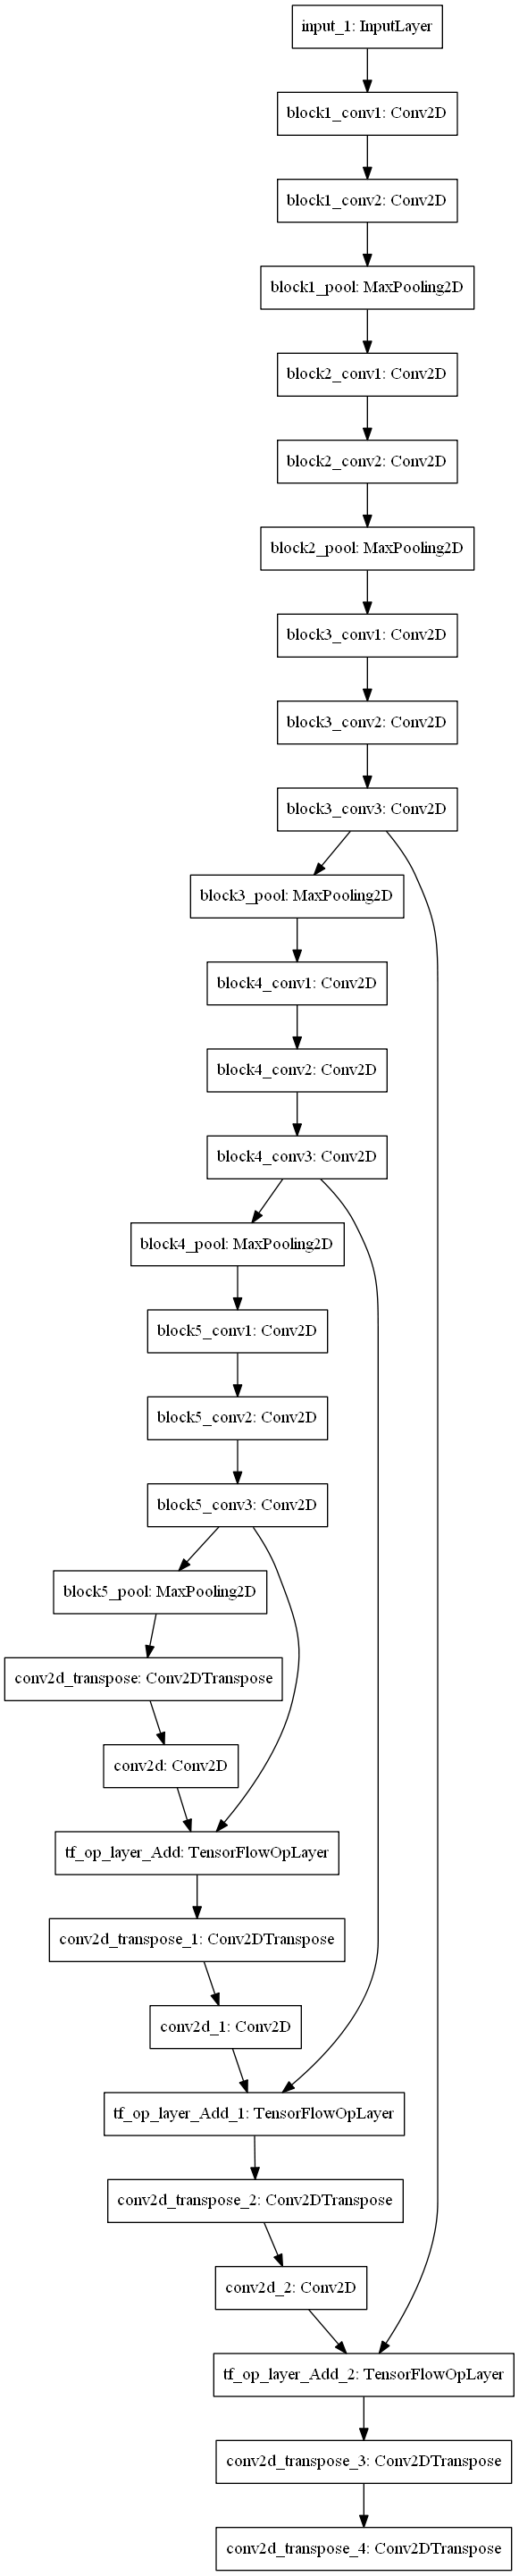

In [23]:
model = tf.keras.models.Model(base_model.input, x)
# 网络可视化
'''
需要：
第一步：pip install pydot
第二步：https://graphviz.gitlab.io/_pages/Download/Download_windows.html 下载graphviz
第三步：解压graphviz，将bin目录添加到环境变量
'''
tf.keras.utils.plot_model(model, to_file='model.png')

In [24]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005), 
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [25]:
train = model.fit(train_data,
                  epochs = 10,
                  steps_per_epoch = train_num // BATCH_SIZE,
                  validation_data = validation_data,
                  validation_steps = val_num // BATCH_SIZE)

Train for 369 steps, validate for 92 steps
Epoch 1/10
369/369 [==============================] - 394s 1s/step - loss: 0.4482 - accuracy: 0.8166 - val_loss: 0.2813 - val_accuracy: 0.8876
Epoch 2/10
369/369 [==============================] - 385s 1s/step - loss: 0.2565 - accuracy: 0.8964 - val_loss: 0.2363 - val_accuracy: 0.9008
Epoch 3/10
369/369 [==============================] - 365s 990ms/step - loss: 0.2217 - accuracy: 0.9087 - val_loss: 0.2124 - val_accuracy: 0.9110
Epoch 4/10
369/369 [==============================] - 396s 1s/step - loss: 0.2010 - accuracy: 0.9168 - val_loss: 0.2123 - val_accuracy: 0.9120
Epoch 5/10
369/369 [==============================] - 505s 1s/step - loss: 0.1912 - accuracy: 0.9199 - val_loss: 0.2164 - val_accuracy: 0.9111
Epoch 6/10
369/369 [==============================] - 535s 1s/step - loss: 0.1773 - accuracy: 0.9248 - val_loss: 0.2004 - val_accuracy: 0.9165
Epoch 7/10
369/369 [==============================] - 531s 1s/step - loss: 0.1629 - accuracy: 0.

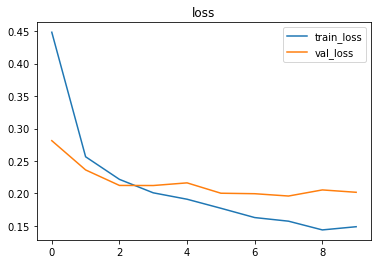

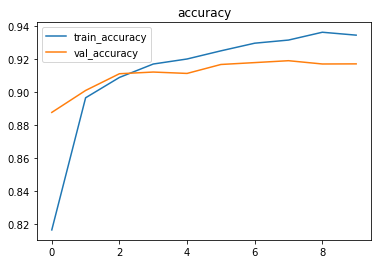

In [26]:
# 训练过程可视化
plt.title("loss")
plt.plot(train.epoch, train.history['loss'], label='train_loss')
plt.plot(train.epoch, train.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

plt.title("accuracy")
plt.plot(train.epoch, train.history['accuracy'], label='train_accuracy')
plt.plot(train.epoch, train.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

## 用模型对验证集进行预测

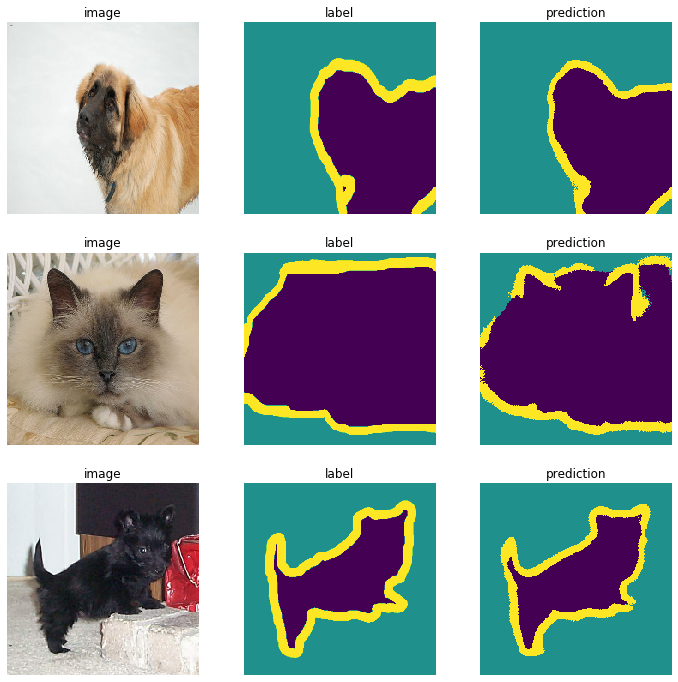

In [27]:
for images, labels in validation_data.shuffle(val_num).take(1):
    preds = model.predict(images)
    preds = tf.argmax(preds, axis=-1)
    # 显示出一个batch的前n张
    n = 3
    plt.figure(figsize=(12, 12))
    for i in range(n):
        # 画原图
        plt.subplot(n, 3, i*n+1)
        plt.title("image")
        plt.axis("off") #去掉坐标系
        plt.imshow(images[i])
        # 画标签图
        plt.subplot(n, 3, i*n+2)
        plt.title("label")
        plt.axis("off")
        plt.imshow(tf.squeeze(labels[i]))
        # 画预测图
        plt.subplot(n, 3, i*n+3)
        plt.title("prediction")
        plt.axis("off")
        plt.imshow(tf.squeeze(preds[i]))

## 交叉熵计算细节

#### categorical_crossentropy

In [28]:
import math
print("-log(0.2):", -math.log(0.2))

-log(0.2): 1.6094379124341003


In [29]:
# -y_true * log(y_pred)
y_true = tf.constant([0, 1, 0])
y_pred = tf.constant([0.1, 0.2, 0.7])
tf.keras.losses.categorical_crossentropy(y_true, y_pred)

<tf.Tensor: id=18067, shape=(), dtype=float32, numpy=1.609438>

In [30]:
# 如果y_true是小数，还是按照原公式计算
y_true = tf.constant([0, 0.1, 0])
y_pred = tf.constant([0.1, 0.2, 0.7])
tf.keras.losses.categorical_crossentropy(y_true, y_pred)

<tf.Tensor: id=18083, shape=(), dtype=float32, numpy=0.16094379>

#### sparse_categorical_crossentropy

In [31]:
y_true = tf.constant([1])
y_pred = tf.constant([0.1, 0.2, 0.7])
tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)

<tf.Tensor: id=18104, shape=(1,), dtype=float32, numpy=array([1.609438], dtype=float32)>

In [32]:
# 如果y_true是小数，则去掉其小数部分
y_true = tf.constant([1.5])
y_pred = tf.constant([0.1, 0.2, 0.7])
tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)

<tf.Tensor: id=18126, shape=(1,), dtype=float32, numpy=array([1.609438], dtype=float32)>